In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from torch.utils.data import ConcatDataset

# Configurações gerais
CWRU_DIR = "../images/CWRU"
HUST_DIR = "../images/HUST"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 4
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Usando dispositivo:", DEVICE)

# Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset completo
cwru_dataset = datasets.ImageFolder(CWRU_DIR, transform=train_transforms)
hust_dataset = datasets.ImageFolder(HUST_DIR, transform=train_transforms)
full_dataset = ConcatDataset([cwru_dataset, hust_dataset])

# Split: 70% treino, 15% val, 15% teste
n_total = len(full_dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [n_train, n_val, n_test])

# Atualiza transforms de val/test
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Modelo: ResNet18 + Fine-Tuning parcial
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Congela tudo

# Substitui o cabeçalho final
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Loss e Otimizador (apenas para o novo cabeçalho)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Treinamento
train_acc_history, val_acc_history = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = correct / total
    train_acc_history.append(train_acc)

    # Validação
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Teste final
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())




Usando dispositivo: cuda


d:\anaconda3\envs\bearing-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\bearing-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15] | Train Acc: 0.5247 | Val Acc: 0.5982
Epoch [2/15] | Train Acc: 0.6212 | Val Acc: 0.6480
Epoch [3/15] | Train Acc: 0.6483 | Val Acc: 0.6647
Epoch [4/15] | Train Acc: 0.6613 | Val Acc: 0.6843
Epoch [5/15] | Train Acc: 0.6885 | Val Acc: 0.6782
Epoch [6/15] | Train Acc: 0.6859 | Val Acc: 0.6903
Epoch [7/15] | Train Acc: 0.6936 | Val Acc: 0.6918
Epoch [8/15] | Train Acc: 0.7121 | Val Acc: 0.7175
Epoch [9/15] | Train Acc: 0.7011 | Val Acc: 0.6903
Epoch [10/15] | Train Acc: 0.7147 | Val Acc: 0.7523
Epoch [11/15] | Train Acc: 0.7095 | Val Acc: 0.7100
Epoch [12/15] | Train Acc: 0.7166 | Val Acc: 0.6903
Epoch [13/15] | Train Acc: 0.7124 | Val Acc: 0.7039
Epoch [14/15] | Train Acc: 0.7185 | Val Acc: 0.7205
Epoch [15/15] | Train Acc: 0.7130 | Val Acc: 0.7326


AttributeError: 'ConcatDataset' object has no attribute 'classes'

              precision    recall  f1-score   support

        ball       0.81      0.48      0.60        63
       inner       0.75      0.86      0.81       273
      normal       0.94      0.79      0.86       128
       outer       0.75      0.77      0.76       199

    accuracy                           0.79       663
   macro avg       0.81      0.73      0.76       663
weighted avg       0.79      0.79      0.78       663



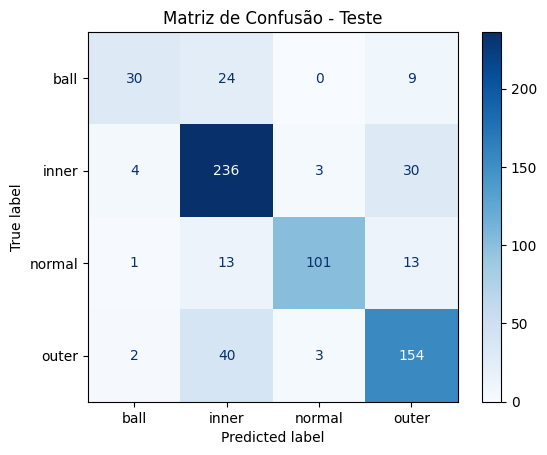

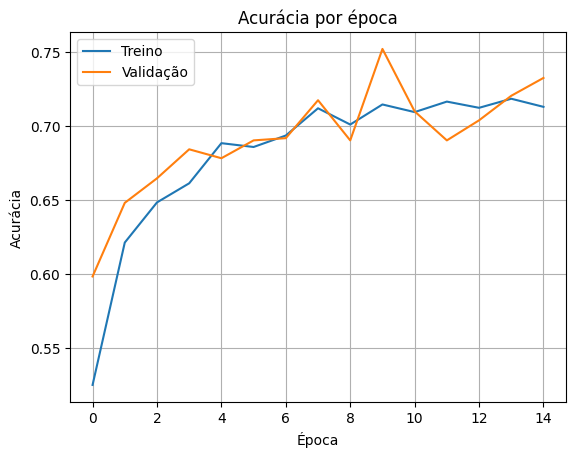

In [3]:
# Relatório e matriz de confusão
class_names = cwru_dataset.classes 
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Teste")
plt.show()

# Plot acurácia por época
plt.plot(train_acc_history, label="Treino")
plt.plot(val_acc_history, label="Validação")
plt.title("Acurácia por época")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()